# Stock Analysis

In this project, we sre going to cover how we can analyse and predict Stock prices using Data Science and Machine Learning algorithms like Linear Regression and  LSTM or Long Short Term Memory network built on the Recursive Neural Network (RNN) architecture.

### Importing Packages

We'll be using NumPy and Pandas for processing the data.

Quandl is used to import the dataset and we have matplotlib to plot graphs.

In [39]:
import pandas as pd
import numpy as np
import quandl

In [40]:
import matplotlib.pyplot as plt

#to plot within notebook
%matplotlib inline

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 20,10

### Importing Data

Importing the stock price data from Quandl.

We then add an index to the dataset replacing Date. Then check the size of the dataset.

In [41]:
df = quandl.get("WIKI/GOOGL")
df.head()
df.reset_index(inplace=True)
df.head()


,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
1,2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2,2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
3,2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
4,2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [42]:
df.shape

(3424, 13)

### ML Libraries

Importing required modules from Keras and sklearn.

In [43]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Next we clean the dataset.  

First we move only the 'Date' and 'Close' columns into a new dataframe as we'll only be using those two parameters for preddiction.  
  
Then we split the dataset into two parts. The larger set will be used to train the model and the smaller one for testing.

In [44]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:2500,:]
valid = dataset[2500:,:]

### Feature Scaling

Our dataset has features highly varying in values. The features with large magnitude will weigh in more and skew our results.  
To prevent this we will scale all the values in the dataset.  

We will use MinMaxScaler class from the sklear.preprocessing library to scale our data between 0 and 1. The feature_range parameter is used to specify the range of the scaled data.

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Shaping the training data

LSTM predicts a value at time T, based on the data from T-N days where N can be any number of steps. We are going to predict the closing stock price of the data based on the closing stock prices for the past 60 days.  


The feature set should contain the closing stock price values for the past 60 days while the dependent variable should be the stock price at the 61st day.  
  
LSTM expects our data to be in a 3D array format so we ned to reshape the training dataset.  
The first dimension is the number of rows in the dataset. The second dimension is the number of time steps which is 60 and the last dimension is the number of indicators( 1 in this case as we're only using the 'Close' stock price.

In [46]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#reshaping the dataset
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### LSTM model

In this step we define our LSTM model.  
__Sequential__ is used instead of __Functional__ as we only need the previous layer for LSTM.  
__Batch_size__ specifies how many parts the dataset is divided into.  
__Epoch__ specifies how many times we're passing the dataset through the model.

In [47]:
# create and fit the LSTM network
model = Sequential()

# return_sequence=True will output a 3D array
# input_shape provides the no. of timestamps and no. of features
# Dense has the output 
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=2, verbose=1)

Epoch 1/1
2440/2440 [==============================] - 34s 14ms/step - loss: 0.0026


Reshaping the test data and then running the model.

In [48]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

No we check the error by performing Root Mean Square Error on the predicted values and the test dataset.

In [49]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

22.772271852417113


### Plotting the result

C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


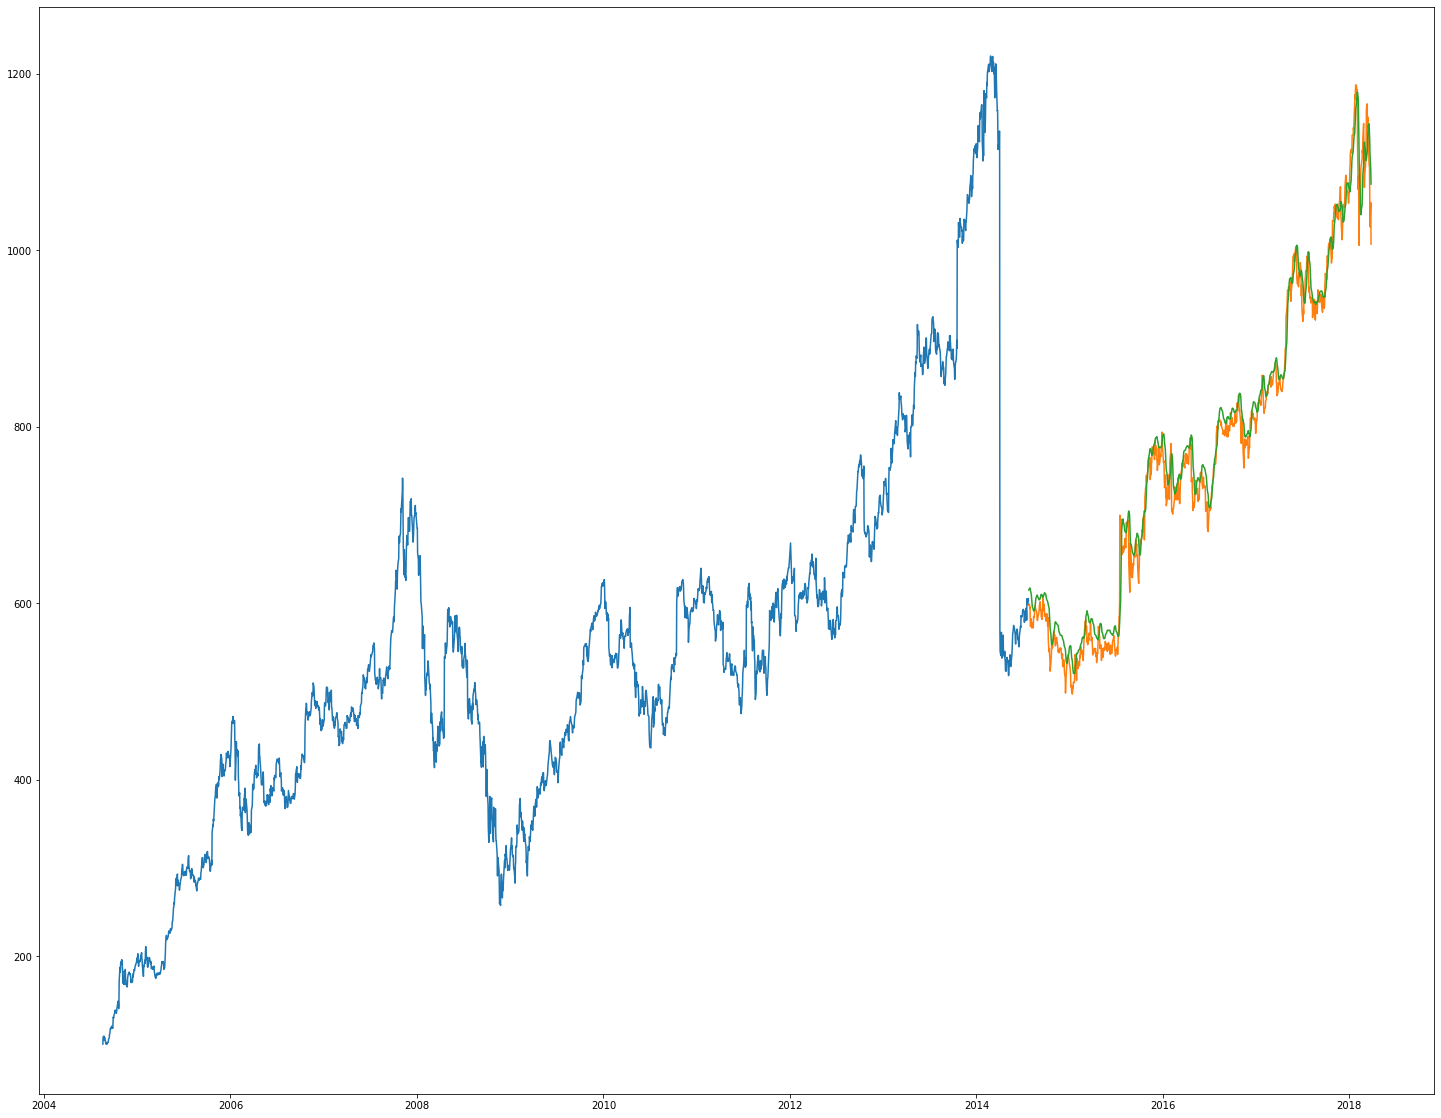

In [51]:
train = new_data[:2500]
valid = new_data[2500:]
valid['Predictions'] = closing_price
fig= plt.figure(figsize=(25,20))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])